## Code to have 2D Maxwell (with B in the direction z) using SummationByParts operators.

This is to be ported to the PIC code.

In [195]:
using Plots
using SummationByPartsOperators
using LinearAlgebra
using ArraysOfArrays
using Base.Threads

In [2]:
include("../../PIC/PIC-1D/aux_functions/aux_functions_grid.jl")
include("../../PIC/PIC-1D/aux_functions/aux_functions_E-B.jl")
include("../../PIC/PIC-1D/aux_functions/aux_functions_RHS.jl")

RK4_Step!! (generic function with 1 method)

In [217]:
J = (100,100)
Box = (0.0,1.0,0.0,1.0)
dx = differentials(Box,J)
D = 2

xv = [(i-1)*dx[1] for i in 1:J[1]]
yv = [(i-1)*dx[2] for i in 1:J[2]];

In [218]:
Dx = periodic_derivative_operator(derivative_order=1, accuracy_order=6, xmin=Box[1], xmax=Box[2], N=J[1])
Dy = periodic_derivative_operator(derivative_order=1, accuracy_order=6, xmin=Box[3], xmax=Box[4], N=J[2])

Periodic first-derivative operator of order 6 on a grid in [0.0, 1.0] using 100 nodes, 
stencils with 3 nodes to the left, 3 nodes to the right, and coefficients of Fornberg (1998) 
  Calculation of Weights in Finite Difference Formulas. 
  SIAM Rev. 40.3, pp. 685-691.

### Initial Data

In [219]:
#k = 2π*[3,3]
#fe(x,y) = sin(k[1]*x)*sin(k[2]*y)
function fp(x,y) 
    x0 = [0.5,0.5]
    r20 = 0.02
    r2 = (x-x0[1])^2+(y-x0[2])^2
    if r2 - r20 < 0
        return (r2 - r20)^2
    else
        return 0.0
    end
end
Ea = [((2-l)*(yv[j] - 0.5) - (l-1)*(xv[i] - 0.5))*fp(xv[i],yv[j]) for l in 1:2, i in 1:J[1], j in 1:J[2]];
B = [fp(xv[i],yv[j]) for i in 1:J[1], j in 1:J[2]];


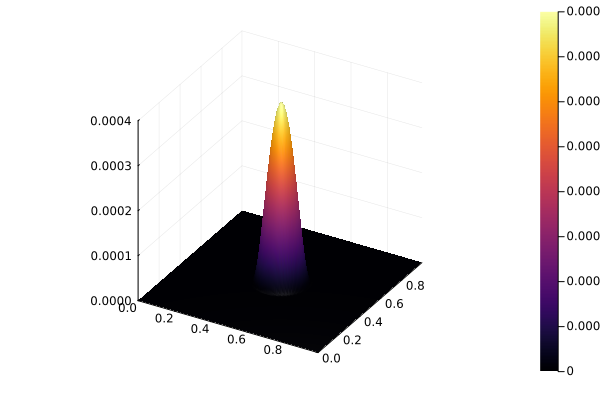

In [220]:
surface(yv,xv,B)

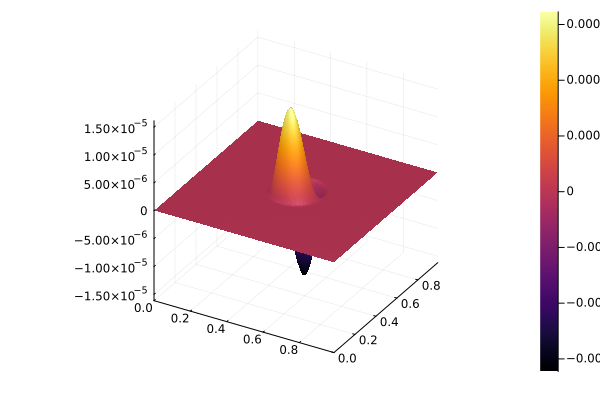

In [221]:
surface(yv,xv,Ea[2,:,:])

We upload the initial data onto the evolution vector.

In [222]:
u = Vector{Float64}(undef,3*J[1]*J[2])
du = Vector{Float64}(undef,3*J[1]*J[2])

F = reshape(u,3,J[1],J[2])

F[1:2,:,:] = Ea
F[3,:,:] = B;

Check that it is OK for this toy data.

In [52]:
@show F[1,30,40]
@show F[2,30,20]
@show F[3,30,20]

F[1, 30, 40] = -0.00021102839999999996
F[2, 30, 20] = 0.0
F[3, 30, 20] = 0.0


0.0

Define the vectors to put the space derivatives.

In [223]:
function F!(u, t, par)
    J, Dx, Dy, du = par
    u_a = reshape(u,(3,J...))
    Du_a = reshape(du,(3,J...))
    @threads for i in 1:J[1]
        mul!(view(Du_a,1,i,:),Dy, view(u_a,3,i,:),one(eltype(u_a)))
        mul!(view(Du_a,3,i,:),Dy, view(u_a,1,i,:),one(eltype(u_a)))
    end
    @threads for j in 1:J[2]
        mul!(view(Du_a,2,:,j),Dx, view(u_a,3,:,j),-one(eltype(u_a)))
        mul!(view(Du_a,3,:,j),Dx, view(u_a,2,:,j),-one(eltype(u_a)),one(eltype(u_a)))
    end
    return du[:]
end

F! (generic function with 1 method)

In [226]:

function get_Energy(u,J,Box)
    U_a = reshape(u,(3,J...))
    return norm(U_a)^2*volume(Box)/prod(J)
end

get_Energy (generic function with 1 method)

In [227]:
(t_i, t_f) = (0.0, 2.0)
M = 2000
@show dt = (t_f - t_i)/M
par = (J, Dx, Dy,du)
t = t_i
Energy = Array{Float64,1}(undef,M+1)
tt = Array{Float64,1}(undef,M+1)
Energy[1] = get_Energy(u,J,Box)
tt[1] = t

dt = (t_f - t_i) / M = 0.001


0.0

In [228]:
F[1:2,:,:] = Ea
F[3,:,:] = B;

for i in 1:M
    RK4_Step!(F!, u, 0.0, dt, par)
    t = t + dt
    tt[i+1] = t
    Energy[i+1] = get_Energy(u,J,Box)
    #println("t = $t")
    #println("Energy = $(get_Energy(u,J,Box))")
end

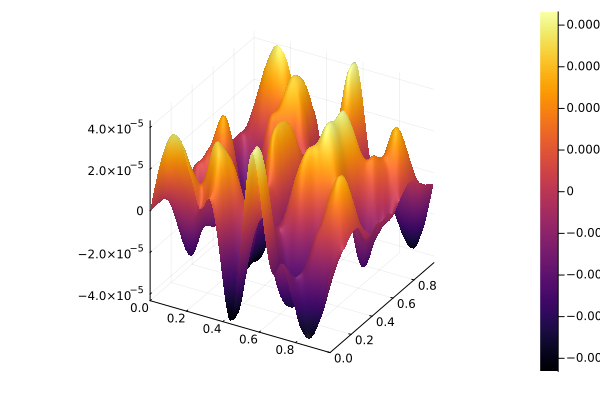

In [229]:
Ef1 = reshape(u,(3,J...))[1,:,:]

surface(yv,xv,Ef1)

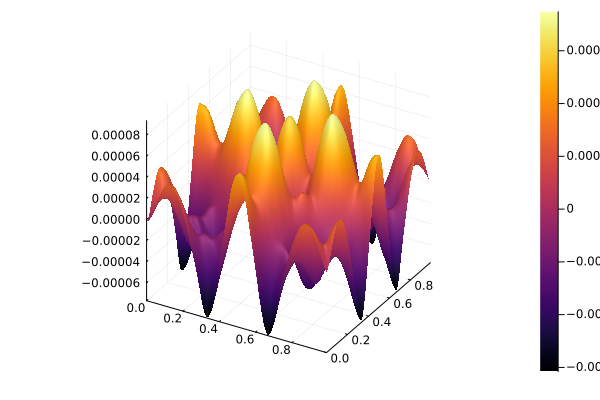

In [230]:
Bf = reshape(u,(3,J...))[3,:,:]

surface(yv,xv,Bf)

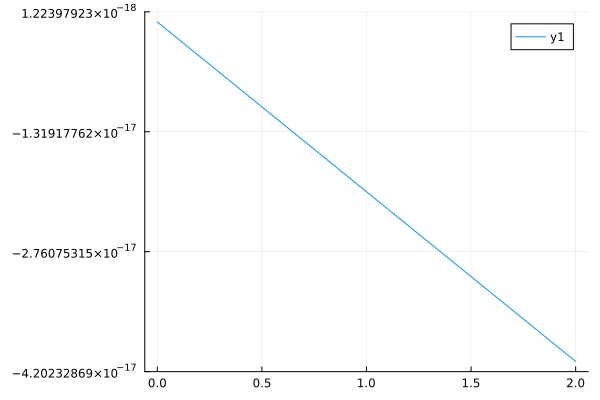

In [231]:
plot(tt,Energy .- Energy[1])

It is working very well. Now we compare with an exact solution.

### Plane wave example

In [204]:
k = 2π*[3,2]; ω = norm(k)
fe(x,y) = sin(k[1]*x + k[2]*y)
#fex(x,y) = k[1]*(-sin(k[1]*x)*cos(k[2]*y) - cos(k[1]*x)*sin(k[2]*y))
#fey(x,y) = k[2]*(-cos(k[1]*x)*sin(k[2]*y) - sin(k[1]*x)*cos(k[2]*y))

B = [fe(xv[i],yv[j]) for i in 1:J[1], j in 1:J[2]];
Ea[1,:,:] = k[2]*B/ω
Ea[2,:,:] = -k[1]*B/ω



1000×1000 Matrix{Float64}:
 -0.0        -0.0104556   -0.0209095   …   0.0209095    0.0104556
 -0.0156828  -0.0261353   -0.0365837       0.00522789  -0.00522789
 -0.0313601  -0.0418058   -0.0522449      -0.0104556   -0.0209095
 -0.0470263  -0.0574614   -0.0678875      -0.0261353   -0.0365837
 -0.0626757  -0.0730966   -0.083506       -0.0418058   -0.0522449
 -0.0783028  -0.0887058   -0.0990948   …  -0.0574614   -0.0678875
 -0.0939022  -0.104284    -0.114648       -0.0730966   -0.083506
 -0.109468   -0.119824    -0.130161       -0.0887058   -0.0990948
 -0.124995   -0.135322    -0.145628       -0.104284    -0.114648
 -0.140478   -0.150772    -0.161043       -0.119824    -0.130161
  ⋮                                    ⋱               
  0.140478    0.130161     0.119824        0.161043     0.150772
  0.124995    0.114648     0.104284        0.145628     0.135322
  0.109468    0.0990948    0.0887058       0.130161     0.119824
  0.0939022   0.083506     0.0730966       0.114648     0.104284

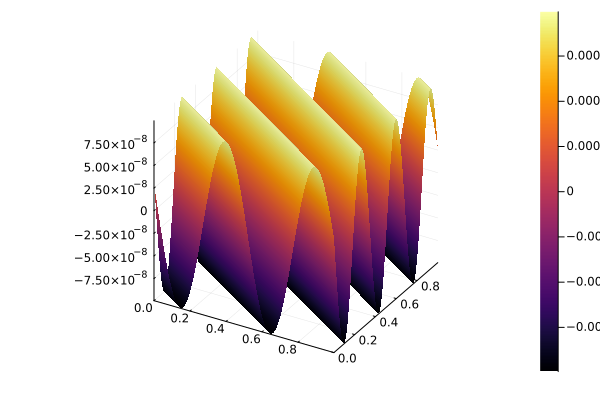

In [215]:
Be(t,ω,k) = [sin(ω*t + k[1]*xv[i] + k[2]*yv[j]) for i in 1:J[1], j in 1:J[2]];
Eae(t,ω) = k[2]/ω*Be
Eae(t,ω) = -k[1]/ω*Be

#plot(yv,xv,(Be(t_i,ω,k)-Bf))
surface(yv,xv,(Be(t_f,ω,k)-Bf))
#surface(xv,xv,(Bf))

#Bf

In [216]:
norm(Be(t_f,ω,k)-Bf)

7.032906051043551e-5

### Results convergence (for the plane wave):

For J=(1000,1000), k = 2π[3,2]

norm(Be(t_f,ω,k)-Bf) = 7.032906051043551e-5
